In [23]:
%load_ext autoreload
%autoreload 2

import cirq
from supermarq.qcvv import SU2

In [24]:
class IndependentDepolariseNoiseModel(cirq.NoiseModel):
    "Applies single and two qubit depolarising channels independently"

    def __init__(self, single_qubit_error: float, two_qubit_error: float) -> None:
        super().__init__()
        self.single_qubit_error = single_qubit_error
        self.two_qubit_error = two_qubit_error
        self.single_qubit_depolarise = cirq.DepolarizingChannel(p=single_qubit_error, n_qubits=1)
        self.two_qubit_depolarise = cirq.DepolarizingChannel(p=two_qubit_error, n_qubits=2)

    def noisy_operation(self, operation: cirq.Operation) -> list[cirq.OP_TREE]:
        if len(operation.qubits) == 1:
            return [operation, self.single_qubit_depolarise(*operation.qubits)]
        if len(operation.qubits) == 2:
            return [operation, self.two_qubit_depolarise(*operation.qubits)]
        return [operation]

noise = IndependentDepolariseNoiseModel(single_qubit_error=0.005, two_qubit_error=0.02)
simulator = cirq.DensityMatrixSimulator(noise=noise)

In [25]:
experiment = SU2()
experiment.run_with_simulator(100, [1, 5, 10, 15, 20, 25], simulator=simulator)
if experiment.collect_data():
    experiment.analyse_results()

Building circuits:   0%|          | 0/600 [00:00<?, ?it/s]

Simulating circuits:   0%|          | 0/600 [00:00<?, ?it/s]

In [26]:
experiment.analyse_results()

(0.9550001840272045, 0.00014693721480291082)

In [27]:
1 - 0.02 * (4/3)

0.9733333333333334

<Axes: xlabel='num_cycles'>

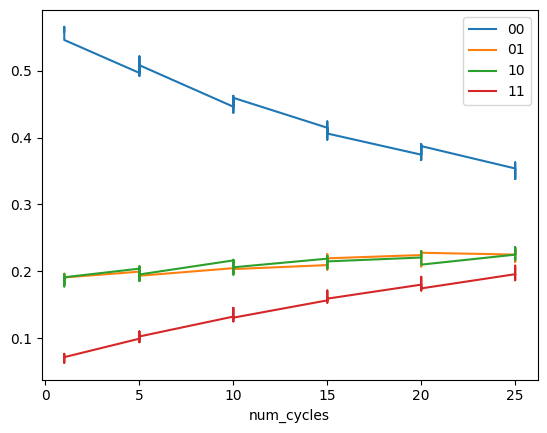

In [28]:
experiment.raw_data.plot(x="num_cycles")